# Homework 3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# Part 3: Sentiment Analysis [40 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment. We intentionally write this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [20]:
import numpy as np
import torch
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
# your code here
import csv
def load_csv(csv_filename):
    labels = []
    tweets = []
    with open(csv_filename, encoding='iso8859') as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            labels.append(int(row[0]))
            tweets.append(row[-1])
    return tweets, np.array(labels)

train_text, train_labels = load_csv('HW3-data/train.csv')
print('Number of positive labels:', (train_labels == 1).sum())
print('Number of negative labels:', (train_labels == 0).sum())

Number of positive labels: 800000
Number of negative labels: 800000


**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [22]:
# your code here
train_dataset = list(zip(train_text, train_labels))

proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size

torch.manual_seed(0)
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [23]:
import spacy
spacy.require_gpu()
from collections import Counter

# there are many ways to preprocess the data; this is just one way
nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser'])
proper_train_tweets = [tweet for tweet, label in proper_train_dataset]
histogram = Counter()
for idx, doc in enumerate(nlp.pipe(proper_train_tweets)):
    if (idx + 1) % 10000 == 0:
        print('Parsing tweet %d/%d, dictionary size: %d' % (idx + 1, proper_train_size, len(histogram)))
    for token in doc:
        lemma = token.lemma_.lower()
        if not (len(lemma.strip()) == 0 \
                or token.pos_ == 'SPACE'):
            histogram[lemma] += 1

vocab_size = 2000
vocab = ['<pad>', '<unk>'] \
    + sorted([word for word, count in histogram.most_common()[:(vocab_size-2)]])
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
print('Vocabulary size:', vocab_size)

Parsing tweet 10000/1280000, dictionary size: 18070
Parsing tweet 20000/1280000, dictionary size: 30016
Parsing tweet 30000/1280000, dictionary size: 40690
Parsing tweet 40000/1280000, dictionary size: 50442
Parsing tweet 50000/1280000, dictionary size: 59643
Parsing tweet 60000/1280000, dictionary size: 68236
Parsing tweet 70000/1280000, dictionary size: 76487
Parsing tweet 80000/1280000, dictionary size: 84484
Parsing tweet 90000/1280000, dictionary size: 92350
Parsing tweet 100000/1280000, dictionary size: 100059
Parsing tweet 110000/1280000, dictionary size: 107685
Parsing tweet 120000/1280000, dictionary size: 115073
Parsing tweet 130000/1280000, dictionary size: 122191
Parsing tweet 140000/1280000, dictionary size: 129093
Parsing tweet 150000/1280000, dictionary size: 135849
Parsing tweet 160000/1280000, dictionary size: 142701
Parsing tweet 170000/1280000, dictionary size: 149362
Parsing tweet 180000/1280000, dictionary size: 155947
Parsing tweet 190000/1280000, dictionary size:

In [24]:
def encode_tweets(tweets):
    n = len(tweets)
    all_encoded = []
    for idx, doc in enumerate(nlp.pipe(tweets)):
        encoded = []
        if (idx + 1) % 10000 == 0:
            print('Parsing tweet %d/%d' % (idx + 1, n))
        for token in doc:
            lemma = token.lemma_.lower()
            if not (len(lemma.strip()) == 0 \
                    or token.pos_ == 'SPACE'):
                if lemma in vocab_to_idx:
                    encoded.append(vocab_to_idx[lemma])
                else:
                    encoded.append(vocab_to_idx['<unk>'])
        all_encoded.append(torch.tensor(encoded, dtype=torch.long))
    return all_encoded

In [25]:
proper_train_encoded = encode_tweets(proper_train_tweets)
proper_train_labels = torch.tensor([label for tweet, label in proper_train_dataset], dtype=torch.long)

Parsing tweet 10000/1280000
Parsing tweet 20000/1280000
Parsing tweet 30000/1280000
Parsing tweet 40000/1280000
Parsing tweet 50000/1280000
Parsing tweet 60000/1280000
Parsing tweet 70000/1280000
Parsing tweet 80000/1280000
Parsing tweet 90000/1280000
Parsing tweet 100000/1280000
Parsing tweet 110000/1280000
Parsing tweet 120000/1280000
Parsing tweet 130000/1280000
Parsing tweet 140000/1280000
Parsing tweet 150000/1280000
Parsing tweet 160000/1280000
Parsing tweet 170000/1280000
Parsing tweet 180000/1280000
Parsing tweet 190000/1280000
Parsing tweet 200000/1280000
Parsing tweet 210000/1280000
Parsing tweet 220000/1280000
Parsing tweet 230000/1280000
Parsing tweet 240000/1280000
Parsing tweet 250000/1280000
Parsing tweet 260000/1280000
Parsing tweet 270000/1280000
Parsing tweet 280000/1280000
Parsing tweet 290000/1280000
Parsing tweet 300000/1280000
Parsing tweet 310000/1280000
Parsing tweet 320000/1280000
Parsing tweet 330000/1280000
Parsing tweet 340000/1280000
Parsing tweet 350000/12

In [26]:
val_encoded = encode_tweets([tweet for tweet, label in val_dataset])
val_labels = torch.tensor([label for tweet, label in val_dataset], dtype=torch.long)

Parsing tweet 10000/320000
Parsing tweet 20000/320000
Parsing tweet 30000/320000
Parsing tweet 40000/320000
Parsing tweet 50000/320000
Parsing tweet 60000/320000
Parsing tweet 70000/320000
Parsing tweet 80000/320000
Parsing tweet 90000/320000
Parsing tweet 100000/320000
Parsing tweet 110000/320000
Parsing tweet 120000/320000
Parsing tweet 130000/320000
Parsing tweet 140000/320000
Parsing tweet 150000/320000
Parsing tweet 160000/320000
Parsing tweet 170000/320000
Parsing tweet 180000/320000
Parsing tweet 190000/320000
Parsing tweet 200000/320000
Parsing tweet 210000/320000
Parsing tweet 220000/320000
Parsing tweet 230000/320000
Parsing tweet 240000/320000
Parsing tweet 250000/320000
Parsing tweet 260000/320000
Parsing tweet 270000/320000
Parsing tweet 280000/320000
Parsing tweet 290000/320000
Parsing tweet 300000/320000
Parsing tweet 310000/320000
Parsing tweet 320000/320000


In [27]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

embedding_weights = torch.Tensor(vocab_size, pretrained_embedding.dim)
for i, word in enumerate(vocab):
    embedding_weights[i] = pretrained_embedding[word]

In [28]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

Epoch 1 [==================================================] 1280000/1280000
  Train accuracy: 0.7790
  Validation accuracy: 0.7760
Epoch 2 [==================================================] 1280000/1280000
  Train accuracy: 0.8053
  Validation accuracy: 0.8014
Epoch 3 [==================================================] 1280000/1280000
  Train accuracy: 0.7994
  Validation accuracy: 0.7945
Epoch 4 [==================================================] 1280000/1280000
  Train accuracy: 0.8050
  Validation accuracy: 0.7995
Epoch 5 [==================================================] 1280000/1280000
  Train accuracy: 0.8012
  Validation accuracy: 0.7949
Epoch 6 [==================================================] 1280000/1280000
  Train accuracy: 0.8131
  Validation accuracy: 0.8065
Epoch 7 [==================================================] 1280000/1280000
  Train accuracy: 0.8149
  Validation accuracy: 0.8085
Epoch 8 [==================================================] 1280000/1280000

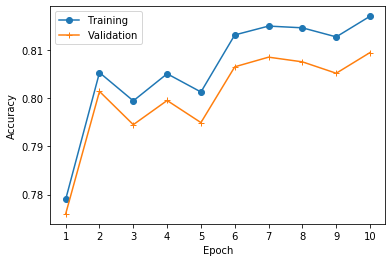

In [29]:
from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 512  # during optimization, how many training data to use at each step
learning_rate = 0.01  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.AdamW(simple_lstm_model.parameters(),
                                                 lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [30]:
test_tweets, test_labels = load_csv('HW3-data/test.csv')
test_dataset = list(zip(test_tweets, test_labels))
test_encoded = encode_tweets([tweet for tweet, label in test_dataset])
test_labels = torch.tensor([label for tweet, label in test_dataset], dtype=torch.long)

predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.6325301204819277


**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [31]:
# your code here
from multiprocessing import Pool

def bag_of_words_encode_tweet(args):
    tweet, vocab_size = args
    feature_vector = np.zeros(vocab_size)
    for word_idx in tweet:
        feature_vector[word_idx] += 1
    return feature_vector

def bag_of_words_encode(already_encoded_tweets):
    p = Pool()
    feature_vectors = p.map(bag_of_words_encode_tweet,
                            [(encoded.cpu().numpy(), vocab_size)
                             for encoded in already_encoded_tweets])
    p.close()
    return feature_vectors

baseline_proper_train_encoded = bag_of_words_encode(proper_train_encoded)
baseline_proper_train_labels = [label for tweet, label in proper_train_dataset]
baseline_val_encoded = bag_of_words_encode(val_encoded)
baseline_val_labels = [label for tweet, label in val_dataset]

In [32]:
from scipy.sparse import csc_matrix

baseline_proper_train_encoded_sparse = csc_matrix(baseline_proper_train_encoded)
baseline_val_encoded_sparse = csc_matrix(baseline_val_encoded)

In [33]:
num_features = vocab_size
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.sqrt(num_features) / 4),
                                                int(np.sqrt(num_features) / 2),
                                                int(np.sqrt(num_features)),
                                                int(np.sqrt(num_features) * 2),
                                                int(np.sqrt(num_features) * 4)]
                           for min_samples_leaf in [1]]
best_val_score = -np.inf  # assumes that a higher score is better
best_model = None

for hyperparam_setting in hyperparameter_settings:
    # your code to train and score the training data here
    max_features, min_samples_leaf = hyperparam_setting
    
    clf = RandomForestClassifier(max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=0, verbose=1, n_jobs=-1,
                                 max_samples=0.1)
    clf.fit(baseline_proper_train_encoded_sparse,
            baseline_proper_train_labels)
    
    predicted_val_labels = clf.predict(baseline_val_encoded_sparse)
    val_score = np.mean(baseline_val_labels == predicted_val_labels)
    
    print(hyperparam_setting, ':', val_score)
    if val_score > best_val_score:  # assumes that a higher score is better
        best_val_score = val_score
        best_hyperparam_setting = hyperparam_setting
        best_model = clf

print('Best hyperparameter setting:', best_hyperparam_setting)
# best_max_features, best_min_samples_leaf = best_hyperparam_setting

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.5s finished


(11, 1) : 0.778803125


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.3s finished


(22, 1) : 0.77644375


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.1s finished


(44, 1) : 0.7723


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.9s finished


(89, 1) : 0.76830625


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.7min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.


(178, 1) : 0.7654125
Best hyperparameter setting: (11, 1)


[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.8s finished


In [34]:
baseline_test_encoded_sparse = csc_matrix(bag_of_words_encode(test_encoded))

baseline_predicted_test_labels = best_model.predict(baseline_test_encoded_sparse)
print('Test accuracy:', np.mean(baseline_predicted_test_labels == test_labels.cpu().numpy()))

[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.


Test accuracy: 0.606425702811245


[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.2s finished
